In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Some helper functions
def to_homogeneous(coordinates):
    # Add a column of ones to the coordinates to make them homogeneous
    return np.hstack((coordinates, np.ones((coordinates.shape[0], 1))))
    
def from_homogeneous(coordinates):
    # Divide by the last column
    return coordinates[:, :2] / coordinates[:, 2][:, None]
    

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(18, 7))
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.set_aspect("equal")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', scale=1, focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = scale*vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

Given a Coordinate system defined by matrix R and transformation T, you can transform the point $x$ to this coordinate system by applying the following transformation:

$$x_t = R^T (x - T)$$

In homogeneous coordinates:

$$x_t = [R^T | -R^T T] x $$

To draw the coordinate system in the orginal coordinates:
$$U = Rx + T$$

In homogeneous coordinates:

$$U = [R | T] x $$


initialize camera pose visualizer


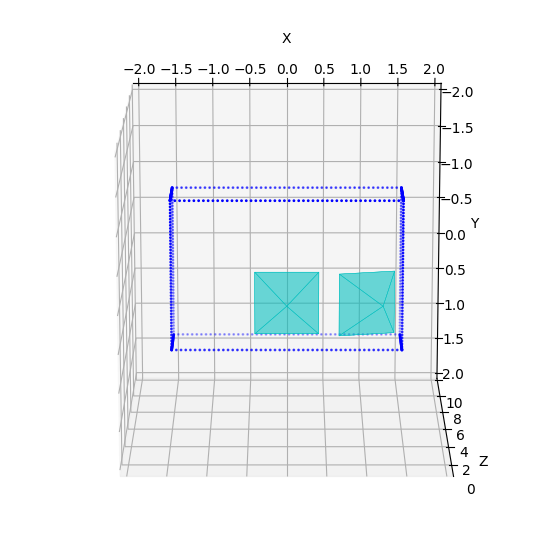

In [4]:
# Define cuboid dimensions and center
width, height, depth = 3, 2, 2
center = np.array([0, 0, 5])
num_points = 50  # Number of points to place along each edge

# Calculate half-dimensions
w, h, d = width / 2, height / 2, depth / 2

# Define the 8 corners of the cuboid
corners = np.array([
    [center[0] - w, center[1] - h, center[2] - d],
    [center[0] + w, center[1] - h, center[2] - d],
    [center[0] + w, center[1] + h, center[2] - d],
    [center[0] - w, center[1] + h, center[2] - d],
    [center[0] - w, center[1] - h, center[2] + d],
    [center[0] + w, center[1] - h, center[2] + d],
    [center[0] + w, center[1] + h, center[2] + d],
    [center[0] - w, center[1] + h, center[2] + d]
])

# Define pairs of corners that form the edges
edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
    (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
    (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
]
# Collect all points along the edges
points = []
for edge in edges:
    start, end = corners[edge[0]], corners[edge[1]]
    for t in np.linspace(0, 1, num_points):
        point = (1 - t) * start + t * end  # Linear interpolation
        points.append(point)

X = np.array(points)
X = to_homogeneous(X)


# Define the two projection matrices corresponding to two cameras
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))

theta = -30 * (np.pi / 180)
R = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]])
T = np.array([3,0,0]).reshape((3,1))
P2 = np.hstack((R.T,-R.T@T))

# Camera 
U1 = np.eye(4)
U2 = np.vstack( ( (np.hstack((R,T))), np.array([0,0,0,1])) )


# Plot the translated point cloud
visualizer = CameraPoseVisualizer([-2, 2], [-2, 2], [-1, 10])
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
visualizer.ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=1, color='b')
visualizer.ax.set_xlabel('X')
visualizer.ax.set_ylabel('Y')
visualizer.ax.set_zlabel('Z')

visualizer.extrinsic2pyramid(U1, 'c', scale=.4, focal_len_scaled=1, aspect_ratio=1)
visualizer.extrinsic2pyramid(U2, 'c', scale=.4, focal_len_scaled=1, aspect_ratio=1)
visualizer.ax.view_init(elev=-75, azim=-90)

plt.show()

([<matplotlib.lines.Line2D at 0x123b62e30>],
 (-0.3629090334355243,
  0.31696426200833816,
  -0.2610283520569644,
  0.2610283520569644))

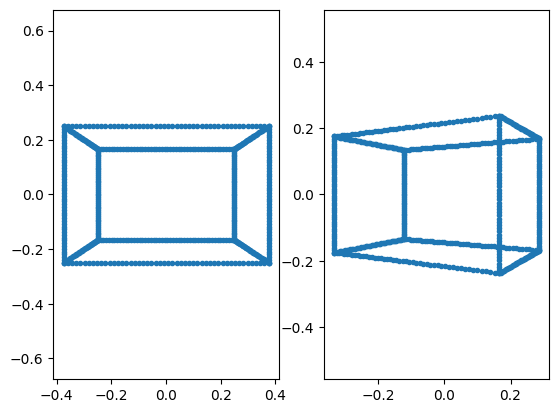

In [6]:
# Projection on the two cameras
pts1 = from_homogeneous(X @ P1.T)
pts2 = from_homogeneous(X @ P2.T)

plt.subplot(1,2,1)
plt.plot(pts1[:,0], pts1[:,1], '.'), plt.axis('equal')
plt.subplot(1,2,2)
plt.plot(pts2[:,0], pts2[:,1], '.'), plt.axis('equal')

In [452]:
K = np.eye(3)
E, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_8POINT)

_, R_, T_, mask= cv.recoverPose(E, pts1, pts2)

# Projection matrics. The R and T returned by recoverPose will form the projection P = [R|T]
P2_ = np.hstack((R_,T_))

In [453]:
pts_4d_hom = cv.triangulatePoints(P1, P2_, pts1.T, pts2.T)
pts_3d = pts_4d_hom[:3] / pts_4d_hom[3]

# Transpose to get points in (N, 3) shape
pts_3d = pts_3d.T

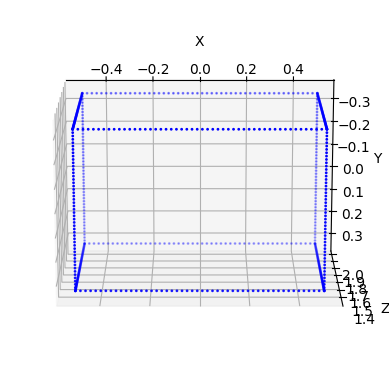

In [475]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_3d[:, 0], pts_3d[:, 1], pts_3d[:, 2], s=1, color='b')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect("equal")
ax.view_init(elev=-75, azim=-90)